<h1><center>Recipe Chatbot Project</center></h1>
<h2><center>DATA-641</center></h2>
<h3><center>Sobanaa Jayakumar & Reina Villanueva-Unger</center></h3>

## 1. Setup
### A. Packages

In [29]:
#basic packages
import os
import pandas as pd
import numpy as np
import string
import re
import statistics

#data processing
import nltk
from nltk.corpus import stopwords
import re
import pickle
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

#feature engg
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical

#model & processing libraries
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn import utils
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#sampling 
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#embeddings
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#DB accesses
import sqlite3 as sq

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#CNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

#encoder
from sklearn.preprocessing import LabelEncoder

#import libraries for chatbot
import argparse
import logging
from typing import Dict
from telegram import ReplyKeyboardMarkup, Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (Updater, CommandHandler, MessageHandler, Filters, ConversationHandler, CallbackContext, CallbackQueryHandler)

### B. Set Paths

i. Data Paths

In [30]:
cuisine_path = "data/cuisine_data/"
recipes_path = "data/recipes_data/"

ii. Model Paths

In [31]:
model_path = "models/nlp"
model_embeddings_path = os.path.join(model_path, 'similarity_embeddings')

### C. Data Import Functions

In [32]:
#Cuisine data
def import_cuisine_data(): 
    train = pd.read_json(os.path.join(cuisine_path, 'train.json'))
    return train

#Recipe Data 
def import_recipe_data():
    all_recipes = pd.read_json('./data/recipes_data/recipes_raw_nosource_allrecipes.json', orient='index')
    epicurious = pd.read_json('./data/recipes_data/recipes_raw_nosource_epicurious.json', orient='index')
    food_network = pd.read_json('./data/recipes_data/recipes_raw_nosource_foodnetwork.json', orient='index')
    data = pd.concat([all_recipes, epicurious, food_network], axis=0)
    
    data = data.reset_index()
    data = data.drop(columns=['index', 'picture_link'])
    return data

### D. Set Cuisine Classes

In [33]:
cuisine_classes = ['greek','southern_us','filipino','indian','jamaican','spanish','italian','mexican','chinese','british','thai','vietnamese','cajun_creole','brazilian','french','japanese','irish','korean','moroccan','russian']

## 2. Pre-Processing

### A. Stopwords

In [34]:
additional_stop_words = ["advertisement", "advertisements",
                         "cup", "cups",
                         "tablespoon", "tablespoons", 
                         "teaspoon", "teaspoons", 
                         "ounce", "ounces",
                         "salt", 
                         "pepper", 
                         "pound", "pounds",
                         ]

stopword_list = stopwords.words("english")
stopword_list.extend(additional_stop_words)

### B. String Cleaning

i. String Cleaning Function

In [36]:
def clean_string(text, stemming=False, lemmatize=True, lst_stopwords=None):
    #clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
     
    lst_text = []    
    #tokenize (convert from string to list)
    if len(text) > 2:
        lst_text = text.split()

    #remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    #stemming (remove -ing, -ly, ...)
    if stemming == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    #lemmatisation (convert the word into root word)
    if lemmatize == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    #back to string from list
    text = " ".join(lst_text)

    #remove digits
    text = ''.join([i for i in text if not i.isdigit()])

    #remove mutliple space
    text = re.sub(' +', ' ', text)

    return text

ii. Preprocess Cuisine Data

In [37]:
def process_cuisine():   #cuisine dataset
    cuisine_data = import_cuisine_data()

    def processing(row):
        ls = row['ingredients']
        return ' '.join(ls)

    cuisine_data['ingredients'] = cuisine_data.apply(lambda x: processing(x), axis=1)
    cuisine_data.dropna(inplace=True)
    cuisine_data = cuisine_data.drop(columns=['id']).reset_index(drop=True)

    cuisine_data["ingredients_query"] = cuisine_data["ingredients"].apply(lambda x: 
          clean_string(x, stemming=False, lemmatize=True, lst_stopwords=stopword_list))
    return cuisine_data

iii. Preprocess Recipes

In [38]:
def process_recipes(data): # Recipes dataset
    data["ingredients_query"] = data["ingredients"].apply(lambda x: 
            clean_string(x, stemming=False, lemmatize=True, lst_stopwords=stopword_list))
    return data

def get_tokenize_text(input_text):
    return clean_string(input_text, stemming=False, lemmatize=True, lst_stopwords=stopword_list)

iv. Defining variables - Cuisine subset

In [39]:
cuisine_subset = process_cuisine().sample(n = 17000)
X_s = cuisine_subset['ingredients_query']
y_s = cuisine_subset['cuisine']

v. Defining variables - Cuisine full dataset

In [41]:
cuisine_data = process_cuisine()
X = cuisine_data['ingredients_query']
y = cuisine_data['cuisine']

## 3. Cuisine Prediction Model

### A. Defining vectorizer

In [42]:
#TFIDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

### B. Defining Test_train split

In [43]:
#using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 123)

### C. Categorization Models

i.a. Logistic Regression - Tuning

In [44]:
lr = LogisticRegression(max_iter = 500, random_state = 123, multi_class = 'multinomial')

In [122]:
#Assigning values to params 
penalty = ['l2', 'l1', 'elasticnet']
C = [0.001, 0.01, 0.1, 10]
solvers = ['newton-cg', 'lbfgs']

#Fitting into pipeline
lr_pipe = Pipeline([('vect', vectorizer), 
                    ('lr', lr)])

#Create hyperparameter dict
hyperparameters = dict(lr__C = C, lr__penalty = penalty, lr__solver = solvers)

#Grid search
clf = GridSearchCV(lr_pipe, hyperparameters, cv = 5)
best_model = clf.fit(X, y)

#Printing best params
print('Best Penalty:', best_model.best_estimator_.get_params()['lr__penalty'])
print('Best C:', best_model.best_estimator_.get_params()['lr__C'])
print('Best Solver:', best_model.best_estimator_.get_params()['lr__solver'])

Best Penalty: l2
Best C: 10
Best Solver: newton-cg


i.b. Logistic Regression - Model

In [15]:
#Fitting vectorizer
matrix_train_lr = vectorizer.fit_transform(X_train)
matrix_test_lr = vectorizer.transform(X_test)

#Fitting final model with Best hyper params
lr_final = LogisticRegression(max_iter = 300, random_state = 123, multi_class ='multinomial', solver = 'newton-cg', C = 10, penalty = 'l2')
lr_final.fit(matrix_train_lr, y_train)
y_pred = lr_final.predict(matrix_test_lr)
pred_prob = lr_final.predict_proba(matrix_test_lr)

#Classification metrics
print('f1 score weighted %s' % f1_score(y_test, y_pred, average = 'weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

acc_lr = accuracy_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred, average = 'weighted')

f1 score weighted 0.7834724049206725
Accuracy score 0.787308930008045
              precision    recall  f1-score   support

   brazilian       0.80      0.57      0.67       117
     british       0.61      0.45      0.52       201
cajun_creole       0.78      0.69      0.73       386
     chinese       0.81      0.87      0.84       668
    filipino       0.79      0.57      0.66       189
      french       0.58      0.67      0.62       662
       greek       0.77      0.69      0.72       294
      indian       0.87      0.91      0.89       751
       irish       0.69      0.49      0.57       167
     italian       0.81      0.89      0.84      1960
    jamaican       0.92      0.71      0.80       131
    japanese       0.85      0.69      0.76       356
      korean       0.86      0.75      0.80       207
     mexican       0.91      0.91      0.91      1610
    moroccan       0.81      0.77      0.79       205
     russian       0.65      0.45      0.53       122
 southern_u



ii.a. Multinomial Naive Bayes - Tuning

In [16]:
nb = MultinomialNB()

In [101]:
#Assigning values to params
alpha = [0.01, 0.1, 0.5, 1.0, 10.0]

#Fitting into pipeline
nb_pipe = Pipeline([('vect', vectorizer), 
                    ('nb', nb)])

#Create hyperparameter dict
hyperparameters = dict(nb__alpha = alpha)

#Grid search
clf = GridSearchCV(nb_pipe, hyperparameters, cv = 5)
best_model = clf.fit(X, y)

#Printing best params
print('Best Alpha:', best_model.best_estimator_.get_params()['nb__alpha'])


Best Alpha: 0.01


ii.b. Multinomial Naive Bayes - Model

In [17]:
#Fitting vectorizer
matrix_train = vectorizer.fit_transform(X_train)
matrix_test = vectorizer.transform(X_test)

nb_final = MultinomialNB(alpha = 0.01)
nb_final.fit(matrix_train, y_train)
y_pred = nb_final.predict(matrix_test)

#Classification metrics
print('f1 score weighted %s' % f1_score(y_test,y_pred, average ='weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

acc_mnb = accuracy_score(y_test, y_pred)
f1_mnb = f1_score(y_test, y_pred, average = 'weighted')

f1 score weighted 0.736116043309851
Accuracy score 0.7412510056315366
              precision    recall  f1-score   support

   brazilian       0.71      0.47      0.57       117
     british       0.52      0.41      0.46       201
cajun_creole       0.66      0.69      0.68       386
     chinese       0.76      0.88      0.81       668
    filipino       0.81      0.49      0.61       189
      french       0.52      0.60      0.56       662
       greek       0.74      0.56      0.64       294
      indian       0.84      0.87      0.86       751
       irish       0.71      0.44      0.54       167
     italian       0.78      0.85      0.81      1960
    jamaican       0.85      0.58      0.69       131
    japanese       0.85      0.64      0.73       356
      korean       0.88      0.65      0.75       207
     mexican       0.88      0.88      0.88      1610
    moroccan       0.76      0.70      0.73       205
     russian       0.66      0.34      0.45       122
 southern_u

iii.a. Random Forest - Tuning

In [18]:
rf = RandomForestClassifier(random_state = 123)

In [193]:
#Assigning values to params 
n_estimators = [10, 100, 500]
max_features = ['sqrt', 'log2']
min_samples_split = [2, 10, 100]
min_samples_leaf = [5, 10] 


#Fitting into pipeline
rf_pipe = Pipeline([('vect', vectorizer), 
                    ('rf', rf)])

#Create hyperparameter dict
hyperparameters = dict(rf__n_estimators = estimators, rf__max_features = max_features, rf__min_samples_split = min_samples_split, rf__min_samples_leaf = min_samples_leaf)

#Grid search
clf = GridSearchCV(rf_pipe, hyperparameters, cv = 5)
best_model = clf.fit(X, y)

#Printing best params
print('Best Estimator:', best_model.best_estimator_.get_params()['rf__n_estimators'])
print('Best features:', best_model.best_estimator_.get_params()['rf__max_features'])
print('Best samples split:', best_model.best_estimator_.get_params()['rf__min_samples_split'])
print('Best samples leaf:', best_model.best_estimator_.get_params()['rf__min_samples_leaf'])
              

Best Estimator: 500
Best features: sqrt
Best samples split: 2
Best samples leaf: 5


iii.b. Random Forest - Model

In [19]:
#Fitting vectorizer
matrix_train_rf = vectorizer.fit_transform(X_train)
matrix_test_rf = vectorizer.transform(X_test)

#Fitting final model with Best hyper params
rf_final = RandomForestClassifier(random_state = 123, n_estimators = 500, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 5)
rf_final.fit(matrix_train_rf, y_train)
y_pred = rf_final.predict(matrix_test_rf)

#Classification metrics
print('f1 score weighted %s' % f1_score(y_test,y_pred, average ='weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

acc_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average = 'weighted')

f1 score weighted 0.5706338276541044
Accuracy score 0.6288213998390989
              precision    recall  f1-score   support

   brazilian       0.85      0.24      0.37       117
     british       1.00      0.00      0.01       201
cajun_creole       0.89      0.49      0.63       386
     chinese       0.61      0.90      0.72       668
    filipino       1.00      0.07      0.14       189
      french       0.58      0.20      0.30       662
       greek       0.93      0.23      0.37       294
      indian       0.78      0.86      0.82       751
       irish       0.80      0.02      0.05       167
     italian       0.56      0.92      0.69      1960
    jamaican       1.00      0.12      0.22       131
    japanese       0.96      0.46      0.62       356
      korean       0.98      0.20      0.34       207
     mexican       0.73      0.91      0.81      1610
    moroccan       0.98      0.21      0.35       205
     russian       0.00      0.00      0.00       122
 southern_

iv.a. SVC - Tuning


In [20]:
svc = SVC(random_state = 123)

In [44]:
#Assigning values to params 
kernel = ['rbf', 'poly', 'sigmoid']  
C = [0.001, 0.01, 0.1, 10]

#Fitting into pipeline
svc_pipe = Pipeline([('vect', vectorizer),
                          ('svc', svc)])

#Create hyperparameter dict
hyperparameters = dict(svc__kernel = kernel, svc__C = C)

#Grid search
clf = GridSearchCV(svc_pipe, hyperparameters, cv = 5)
best_model = clf.fit(X_s, y_s)

#Printing best params
print('Best Kernel:', best_model.best_estimator_.get_params()['svc__kernel'])
print('Best C:', best_model.best_estimator_.get_params()['svc__C'])

Best Kernel: sigmoid
Best C: 10


iv.b. SVC - Model

In [21]:
#Fitting vectorizer
matrix_train = vectorizer.fit_transform(X_train)
matrix_test = vectorizer.transform(X_test)

#Fitting final model with Best hyper params
svc_final = SVC(random_state = 123, kernel = 'sigmoid', C = 10)
svc_final.fit(matrix_train, y_train)
y_pred = svc_final.predict(matrix_test)

#Classification metrics
print('f1 score weighted %s' % f1_score(y_test,y_pred, average='weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

acc_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred, average = 'weighted')

f1 score weighted 0.7521964647011117
Accuracy score 0.7526146419951729
              precision    recall  f1-score   support

   brazilian       0.67      0.65      0.66       117
     british       0.49      0.53      0.51       201
cajun_creole       0.71      0.69      0.70       386
     chinese       0.79      0.84      0.81       668
    filipino       0.67      0.61      0.64       189
      french       0.50      0.64      0.56       662
       greek       0.68      0.69      0.68       294
      indian       0.85      0.88      0.86       751
       irish       0.51      0.47      0.49       167
     italian       0.80      0.82      0.81      1960
    jamaican       0.85      0.76      0.80       131
    japanese       0.76      0.68      0.72       356
      korean       0.84      0.74      0.78       207
     mexican       0.89      0.89      0.89      1610
    moroccan       0.77      0.76      0.77       205
     russian       0.57      0.41      0.48       122
 southern_

v.a. XGB - Tuning

In [156]:
import xgboost as xgb

In [155]:
xgb_model = xgb.XGBClassifier(objective = 'multi:softmax')

In [ ]:
max_depth = [1, 5, 20, 50]
gamma = [1, 10]
reg_alpha = [1, 40, 180]
reg_lambda = [0, 1]
colsample_bytree = [0.5, 1]
min_child_weight = [0, 1, 10]
eta = [0.5, 1]


xgb_pipe = Pipeline([('vect', vectorizer),
                      ('xgb', xgb_model)])

#Create hyperparameter dict
hyperparameters = dict(xgb__max_depth = max_depth, xgb__gamma = gamma, xgb__reg_alpha = reg_alpha, 
                       xgb__reg_lambda = reg_lambda, xgb__colsample_bytree = colsample_bytree, xgb__min_child_weight = min_child_weight, xgb__eta = eta)

#Grid search
clf = GridSearchCV(xgb_pipe, hyperparameters, cv = 5)
best_model = clf.fit(X_s, y_s)

#Printing best params
print('Best Depth:', best_model.best_estimator_.get_params()['xgb__max_depth'])
print('Best Gamma:', best_model.best_estimator_.get_params()['xgb__gamma'])
print('Best Alpha:', best_model.best_estimator_.get_params()['xgb__reg_alpha'])
print('Best Lambda:', best_model.best_estimator_.get_params()['xgb__reg_lambda'])
print('Best Colsample:', best_model.best_estimator_.get_params()['xgb__colsample_bytree'])
print('Best Child weight:', best_model.best_estimator_.get_params()['xgb__min_child_weight'])
print('Best ETA:', best_model.best_estimator_.get_params()['xgb__eta'])

v.b. XGB - Model

In [158]:
#Fitting vectorizer
matrix_train = vectorizer.fit_transform(X_train)
matrix_test = vectorizer.transform(X_test)

#Fitting final model with Best hyper params. Import xgb before running this
xgb_final = xgb.XGBClassifier(objective = 'multi:softmax', max_depth = 1, gamma = 1, reg_alpha = 1, 
                     reg_lambda = 0, colsample_bytree = 0.5, min_child_weight = 1, eta = 0.5, eval_metric = 'mlogloss')

xgb_final.fit(matrix_train, y_train)
y_pred = xgb_final.predict(matrix_test)

#Classification metrics
print('f1 score weighted %s' % f1_score(y_test,y_pred, average='weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

acc_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average = 'weighted')

f1 score weighted 0.7377902089531876
Accuracy score 0.7453740949316171
              precision    recall  f1-score   support

   brazilian       0.78      0.53      0.63       117
     british       0.50      0.24      0.33       201
cajun_creole       0.79      0.67      0.73       386
     chinese       0.78      0.84      0.81       668
    filipino       0.68      0.48      0.57       189
      french       0.54      0.55      0.54       662
       greek       0.81      0.70      0.75       294
      indian       0.86      0.86      0.86       751
       irish       0.62      0.43      0.50       167
     italian       0.70      0.88      0.78      1960
    jamaican       0.89      0.67      0.77       131
    japanese       0.85      0.65      0.73       356
      korean       0.79      0.66      0.72       207
     mexican       0.88      0.89      0.89      1610
    moroccan       0.81      0.71      0.76       205
     russian       0.58      0.34      0.43       122
 southern_

vi.a. Over and Under Sampling

In [159]:
lr_samp = LogisticRegression(max_iter = 300, random_state = 123, multi_class = 'multinomial',  solver = 'newton-cg', C = 10, penalty = 'l2')

In [160]:
random_os = RandomOverSampler(random_state=123)
random_us = RandomUnderSampler(random_state=123)

vi.b. Oversampling LR

In [161]:
lr_pipe_os = pl.make_pipeline(vectorizer,
                           random_os,
                           lr_samp)


#Train the classifier with balancing
lr_pipe_os.fit(X_train, y_train)

#Test the classifier and get the prediction
y_pred_bal = lr_pipe_os.predict(X_test)

print("results on oversampling:\n")
print('f1 score weighted %s' % f1_score(y_test, y_pred_bal, average = 'weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred_bal))
print(classification_report_imbalanced(y_test, y_pred_bal))

acc_os_lr = accuracy_score(y_test, y_pred_bal)
f1_os_lr = f1_score(y_test, y_pred_bal, average = 'weighted')

results on oversampling:

f1 score weighted 0.7856498439972385
Accuracy score 0.7844931617055511
                    pre       rec       spe        f1       geo       iba       sup

   brazilian       0.70      0.68      1.00      0.69      0.82      0.65       117
     british       0.53      0.57      0.99      0.55      0.75      0.54       201
cajun_creole       0.74      0.75      0.99      0.74      0.86      0.72       386
     chinese       0.82      0.85      0.99      0.83      0.91      0.82       668
    filipino       0.72      0.65      0.99      0.68      0.80      0.63       189
      french       0.58      0.68      0.96      0.62      0.81      0.63       662
       greek       0.71      0.77      0.99      0.74      0.87      0.74       294
      indian       0.89      0.90      0.99      0.90      0.95      0.89       751
       irish       0.57      0.57      0.99      0.57      0.75      0.54       167
     italian       0.85      0.83      0.96      0.84      0.8

vi.c. Undersampling LR

In [162]:
lr_pipe_us = pl.make_pipeline(vectorizer,
                           random_us,
                           lr_samp)



#Train the classifier with balancing
lr_pipe_us.fit(X_train, y_train)

#Test the classifier and get the prediction
y_pred_bal = lr_pipe_us.predict(X_test)

print("results on Undersampling:\n")
print('f1 score weighted %s' % f1_score(y_test, y_pred_bal, average = 'weighted'))
print('Accuracy score %s' % accuracy_score(y_test, y_pred_bal))
print(classification_report_imbalanced(y_test, y_pred_bal))

acc_us_lr = accuracy_score(y_test, y_pred_bal)
f1_us_lr = f1_score(y_test, y_pred_bal, average = 'weighted')

results on Undersampling:

f1 score weighted 0.7209825708033166
Accuracy score 0.7059533386967015
                    pre       rec       spe        f1       geo       iba       sup

   brazilian       0.41      0.76      0.99      0.54      0.87      0.73       117
     british       0.31      0.61      0.97      0.41      0.77      0.57       201
cajun_creole       0.63      0.76      0.98      0.69      0.86      0.73       386
     chinese       0.85      0.77      0.99      0.81      0.87      0.75       668
    filipino       0.49      0.68      0.99      0.57      0.82      0.65       189
      french       0.51      0.54      0.96      0.52      0.72      0.49       662
       greek       0.60      0.79      0.98      0.68      0.88      0.76       294
      indian       0.91      0.83      0.99      0.87      0.91      0.81       751
       irish       0.35      0.63      0.98      0.45      0.79      0.59       167
     italian       0.89      0.67      0.98      0.76      0.

vii. CNN 

In [163]:
train_labels = y_train
test_labels = y_test
train_texts = X_train
test_texts = X_test

In [164]:
#Defining parameters for keras
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 50000 
VALIDATION_SPLIT = 0.2

In [165]:
#conversion of label data
le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

In [166]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts) 
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2661 unique tokens.


In [167]:
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(train_labels, num_classes = 20, dtype ="int32")
test_labels = to_categorical(test_labels, num_classes = 20, dtype ="int32")

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [195]:
#Training our own embeddings
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel_own = Sequential()
cnnmodel_own.add(Embedding(MAX_NUM_WORDS, 128))
cnnmodel_own.add(Conv1D(128, 5, activation='relu'))
cnnmodel_own.add(MaxPooling1D(5))
cnnmodel_own.add(Dropout(0.5))
cnnmodel_own.add(Conv1D(128, 5, activation='relu'))
cnnmodel_own.add(MaxPooling1D(5))
cnnmodel_own.add(Dropout(0.5))
cnnmodel_own.add(Conv1D(128, 5, activation='relu'))
cnnmodel_own.add(GlobalMaxPooling1D())
cnnmodel_own.add(Dense(128, activation='relu'))
cnnmodel_own.add(Dropout(0.5))
cnnmodel_own.add(Dense(len(trainvalid_labels[0]), activation='softmax'))

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings


In [170]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
cnnmodel_own.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

# fit the model
history = cnnmodel_own.fit(x_train, y_train,
                            batch_size = 16, 
                            epochs = 5, verbose=1, validation_data=(x_val, y_val))

# evaluate the model
loss, accuracy, f1_score, precision, recall = cnnmodel_own.evaluate(test_data, test_labels, verbose = 0)

Epoch 1/5
1492/1492 [==============================] - 872s 580ms/step - loss: 1.0888 - acc: 0.6739 - f1_m: 0.6579 - precision_m: 0.8457 - recall_m: 0.5459 - val_loss: 1.1350 - val_acc: 0.6664 - val_f1_m: 0.6569 - val_precision_m: 0.8514 - val_recall_m: 0.5419
Epoch 2/5
1492/1492 [==============================] - 785s 526ms/step - loss: 1.0483 - acc: 0.6830 - f1_m: 0.6688 - precision_m: 0.8467 - recall_m: 0.5597 - val_loss: 1.1056 - val_acc: 0.6765 - val_f1_m: 0.6568 - val_precision_m: 0.8700 - val_recall_m: 0.5347
Epoch 3/5
1492/1492 [==============================] - 570s 382ms/step - loss: 1.0183 - acc: 0.6928 - f1_m: 0.6774 - precision_m: 0.8512 - recall_m: 0.5700 - val_loss: 1.1091 - val_acc: 0.6812 - val_f1_m: 0.6640 - val_precision_m: 0.8625 - val_recall_m: 0.5471
Epoch 4/5
1492/1492 [==============================] - 631s 423ms/step - loss: 0.9824 - acc: 0.7024 - f1_m: 0.6891 - precision_m: 0.8537 - recall_m: 0.5850 - val_loss: 1.1012 - val_acc: 0.6827 - val_f1_m: 0.6727 - val

In [196]:
print(f'accuracy: {accuracy}')
print(f'f1 score: {f1_score}')

accuracy: 0.6854384541511536
f1 score: 0.671891450881958


vii. a. CNN - Training and Validation accuracy plot

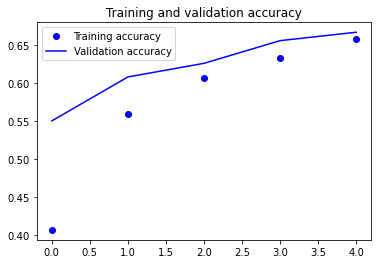

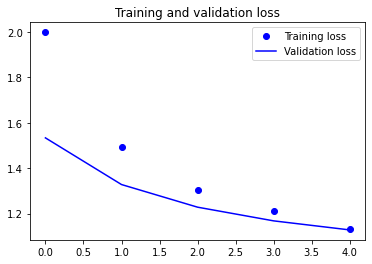

In [172]:
import matplotlib.pyplot as plt

accuracy = cnn_train.history['acc']
val_accuracy = cnn_train.history['val_acc']
loss = cnn_train.history['loss']
val_loss = cnn_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

viii. Dataframe with Scores

In [197]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'XG Boost Model', 'Logistic Regression - Oversampled', 
              'Logistic Regression - Undersampled', 'Naive Bayes', 'Random Forest', 'CNN'],
    'Accuracy Score': [acc_lr, acc_svm, acc_xgb, acc_os_lr, acc_us_lr, acc_mnb, acc_rf, accuracy],
    'F1 Score': [f1_lr, f1_svm, f1_xgb, f1_os_lr, f1_us_lr, f1_mnb,  f1_rf, f1_score]})

models.sort_values(by = 'Accuracy Score', ascending = False)

,Model,Accuracy Score,F1 Score
0,Logistic Regression,0.787309,0.783472
3,Logistic Regression - Oversampled,0.784493,0.785650
1,Support Vector Machines,0.752615,0.752196
2,XG Boost Model,0.745374,0.737790
5,Naive Bayes,0.741251,0.736116
4,Logistic Regression - Undersampled,0.705953,0.720983
7,CNN,0.685438,0.671891
6,Random Forest,0.628821,0.570634


### E. Fitting Best Model - Logistic Regression

i. Saving & Loading Pickle

In [57]:
#Load pkl
def load_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as pkl_file:
        return pickle.load(pkl_file)
    
#Save pkl
def save_pkl(file, pkl_filename):
    with open(pkl_filename, 'wb') as pkl_file:
        pickle.dump(file, pkl_file)

ii. Fitting model

In [18]:
#TFIDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

#using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 123)

In [19]:
def create_model_cuisine_predictions():
    classifier = LogisticRegression(random_state=123,
                                      max_iter=300,
                                      n_jobs=-1,
                                      multi_class = 'multinomial', 
                                      solver = 'newton-cg', 
                                      C = 10, 
                                      penalty = 'l2') 
    #Pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                                ("classifier", classifier)])
 

    #Fit Model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_train)
 
    #Save as Pkl
    save_pkl(model, os.path.join(model_path, "pickle_model.pkl"))

iii. Check function

In [37]:
create_model_cuisine_predictions()

### F. Creating a Database

In [45]:
model_path = 'models/nlp'

def create_and_populate_db():
    data = import_recipe_data()
    
    #Process the data
    data = process_recipes(data)
    
    #Predict cuisine from trained model
    model = load_pkl(os.path.join(model_path, 'pickle_model.pkl'))
    data["cuisine"] = model.predict(data["ingredients_query"].tolist())  #this is predicting cuisine for recipe dataset
    
    db = sq.connect('recipes.db')
    #Verify dtypes
    for col in data.columns:
        data[col] = data[col].astype('str')

    print(' ------------------ Check data before populating the db ------------------')
    print(data.columns)
    print(data.head())
    print(data.shape)
    data.to_sql('main_recipes', db, if_exists='replace')

In [38]:
create_and_populate_db()

 ------------------ Check data before populating the db ------------------
Index(['title', 'ingredients', 'instructions', 'ingredients_query', 'cuisine'], dtype='object')
                               title  \
0  Slow Cooker Chicken and Dumplings   
1      Awesome Slow Cooker Pot Roast   
2               Brown Sugar Meatloaf   
3        Best Chocolate Chip Cookies   
4  Homemade Mac and Cheese Casserole   

                                         ingredients  \
0  ['4 skinless, boneless chicken breast halves A...   
1  ['2 (10.75 ounce) cans condensed cream of mush...   
2  ['1/2 cup packed brown sugar ADVERTISEMENT', '...   
3  ['1 cup butter, softened ADVERTISEMENT', '1 cu...   
4  ['8 ounces whole wheat rotini pasta ADVERTISEM...   

                                        instructions  \
0  Place the chicken, butter, soup, and onion in ...   
1  In a slow cooker, mix cream of mushroom soup, ...   
2  Preheat oven to 350 degrees F (175 degrees C)....   
3  Preheat oven to 350 degr

In [46]:
def get_df_from_db(cuisine):
    db = sq.connect('recipes.db')
    sql_query = "SELECT title, instructions, ingredients, ingredients_query FROM main_recipes WHERE cuisine = ?"
    return pd.read_sql(sql_query, db, params = (cuisine, ))

### G. Doc2Vec function for recipe similarity

In [47]:
def d2v_embeddings(data): #Recipe dataset
    data = data['ingredients_query'].tolist()
    tagged_data = [TaggedDocument(words=row.split(), tags=[str(index)]) for index, row in enumerate(data)]

    max_epochs = 50
    vec_size = 200
    alpha = 0.025

    model_embedding = Doc2Vec(vector_size=vec_size,
                        alpha=alpha, 
                        min_alpha=0.00025,
                        min_count=3,
                        dm =0, # Paragraph Vector - Distributed Bag of Words
                        window=5)
  
    model_embedding.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model_embedding.train(tagged_data,
                    total_examples=model_embedding.corpus_count,
                    epochs=model_embedding.epochs)
        # decrease the learning rate
        model_embedding.alpha -= 0.0002
        # fix the learning rate, no decay
        model_embedding.min_alpha = model_embedding.alpha
        # vector size
        model_embedding.vector_size /= 2
        # window
        model_embedding.window -= 2
 
    return model_embedding

In [48]:
def train_model_embeddings():
    db = sq.connect('recipes.db')
    cursor = db.cursor()
    
    for cuisine in cuisine_classes:
        sql_query = f"SELECT title, instructions, ingredients, ingredients_query FROM main_recipes WHERE cuisine = ?"
        data = pd.read_sql(sql_query, db, params=(cuisine,))
        
        model_embedding = d2v_embeddings(data)
        save_pkl(model_embedding, os.path.join(model_embeddings_path, f'd2v_{cuisine}.pkl'))

In [ ]:
train_model_embeddings()

### H. Final functions for Chatbot construction

i. Predict Cuisine function

In [49]:
def predict_cuisine(input_text):
    top = 3

    #Tokenize text
    tokenize_text = get_tokenize_text(input_text)

    #Get model
    model_def = os.path.join(model_path, 'pickle_model.pkl')
    model = load_pkl(model_def)

    #Tokenize text
    tokenize_text = get_tokenize_text(input_text)
 
    #Get classes ordered by probability
    proba = model.predict_proba([tokenize_text])[0]
 
    #Sorted index list 
    indexes = sorted(range(len(proba)), key = lambda k: proba[k], reverse=True)
 
    #Get cuisine
    cuisine_labels = model.classes_.tolist()
    cusine_ordered = [cuisine_labels[ind] for ind in indexes]
 
    return cusine_ordered[: top]

ii. Getting similar recipes function

In [50]:
def get_similar_recipes(input_text, cuisine, top_k = 3):
    #Tokenize text
    tokenize_text = get_tokenize_text(input_text).split()
    
    #Load model from the selected cuisine
    d2v = load_pkl(os.path.join(model_embeddings_path, f'd2v_{cuisine}.pkl'))

    #Get embeddings
    embeddings = d2v.infer_vector(tokenize_text)
    best_recipes = d2v.docvecs.most_similar([embeddings]) #gives you top 10 document tags and their cosine similarity

    #Get recipes
    best_recipes_index = [int(output[0]) for output in best_recipes]
    
    #Get dDtaFrame
    df = get_df_from_db(cuisine)
    
    return df[df.index.isin(best_recipes_index)].head(top_k)

### I. Telegram Chatbot Construction

i. Defining the initial arguments

In [51]:
#Create the parser
my_parser = argparse.ArgumentParser(description = 'Give your personal token')

#Add the arguments
my_parser.add_argument('token', metavar = 'token', type = str, help = 'The token given by Fatherbot')


#Enable logging
logging.basicConfig(
    #filename= 'telgramBot.log',
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

logger = logging.getLogger(__name__)

#Main interactions ----
CHOOSING, GET_TEXT = range(2)
#Callback data
CALLBACK1, CALLBACK2 = range(3, 5)

reply_keyboard = [
    ['Show ingredients', 'Get recipes'],
    ['Remove item', 'Done'],
]
markup = ReplyKeyboardMarkup(reply_keyboard, one_time_keyboard=False)

ii. Functions for the chatbot flow 

In [52]:
def start(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info(f"{user.first_name}: Start")

    context.user_data['chat_id'] = update.message.chat_id

    update.message.reply_text(
        "Hi! I am your recipe bot. What ingredients do you currently have? "
        "You can add ingredients by typing it in one or two words",
        reply_markup=markup,
    )
    return CHOOSING


def get_basket_txt(list_ingredients):
    txt = 'Here are your current ingredients:\n'
    for ingredient in list_ingredients:
        txt += f'   - {ingredient}\n'
    return txt


In [53]:
def button1(update: Update, context: CallbackContext) -> int:
    logger.info(f": button1")

    query = update.callback_query
    query.answer()

    user_data = context.user_data    
    if 'ingredients_list' not in user_data:
        user_data['ingredients_list'] = [query.data]
    else:
        user_data['ingredients_list'].append(query.data)

    query.edit_message_text(text=f"Ok you selected: {query.data}")
    
    txt = get_basket_txt(user_data['ingredients_list'])
    context.bot.send_message(chat_id=context.user_data['chat_id'], text=txt)

    return CHOOSING


def recipes_query(update: Update, context: CallbackContext) -> int:
    """ Get recipes """
    user = update.message.from_user
    logger.info(f"{user.first_name}: recipes_query")

    user_data = context.user_data

    input_text = ' '.join(user_data['ingredients_list'])

    # Predict cuisine
    cuisine = predict_cuisine(input_text)

    keyboard = [
        [
            InlineKeyboardButton(cuisine[0], callback_data=cuisine[0]),
            InlineKeyboardButton(cuisine[1], callback_data=cuisine[1]),
            InlineKeyboardButton(cuisine[2], callback_data=cuisine[2])]
    ]
    reply_markup = InlineKeyboardMarkup(keyboard)
    # Send message with text and appended InlineKeyboard
    update.message.reply_text("Chose the type of cuisine you want!", reply_markup=reply_markup)

    return CALLBACK2


In [54]:
def button2(update: Update, context: CallbackContext) -> int:
    #user = update.message.from_user
    logger.info(f"button2")

    query = update.callback_query
    query.answer()

    # Get recipes
    recipes = get_similar_recipes(context.user_data['ingredients_list'], query.data)

    sep = '\n\n'
    for index, row in recipes.iterrows():

        title = 'Title: ' + row['title'] 
        ingredients=''
        list_ing = row['ingredients'].replace('ADVERTISEMENT', '').strip('][').split(', ')
        for ingredient in list_ing:
            ingredients+= ingredient.replace("'", "") + '\n'
        ingredients = 'Ingredients: ' + '\n' + ingredients
        instructions = 'Instruction: '+ '\n' + row['instructions']

        txt = title + sep + ingredients + sep + instructions

        context.bot.send_message(chat_id=context.user_data['chat_id'], text=txt)

    return CHOOSING


def show_basket(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info(f"{user.first_name}: show_basket")

    user_data = context.user_data
    
    txt = get_basket_txt(user_data['ingredients_list'])
    
    update.message.reply_text(
        txt,
        reply_markup=markup,
    )
    return CHOOSING


def received_text_information(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info(f"{user.first_name}: received_text_information")

    user_data = context.user_data
    text = update.message.text
    
    if 'ingredients_list' not in user_data:
        user_data['ingredients_list'] = [text]
    else:
        user_data['ingredients_list'].append(text)

    txt = get_basket_txt(user_data['ingredients_list'])
    update.message.reply_text(
        txt,
        reply_markup=markup,
    )
    return CHOOSING


def remove_item(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info(f"{user.first_name}: remove_item")

    user_data = context.user_data
    if 'ingredients_list' in user_data:
        del user_data['ingredients_list'][-1]
    
    introduction = 'You have deleted the last ingredient. '
    txt = get_basket_txt(user_data['ingredients_list'])
    update.message.reply_text(
        introduction + txt,
        reply_markup=markup,
    )
    return CHOOSING


In [55]:
def done(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info(f"{user.first_name}: done")

    user_data = context.user_data
    if 'ingredients_list' in user_data:
        del user_data['ingredients_list']

    update.message.reply_text(
        f"Goodbye for now!"
    )

    user_data.clear()
    return ConversationHandler.END    


iii. Putting it all together

In [27]:
def main(bot_token) -> None:
    updater = Updater(bot_token, use_context=True)

    # Get the dispatcher to register handlers
    dispatcher = updater.dispatcher

    # Add conversation handler with the states CHOOSING, TYPING_CHOICE and TYPING_REPLY
    conv_handler = ConversationHandler(
        entry_points=[CommandHandler('start', start)],
        states={
            CHOOSING: [
                MessageHandler(Filters.text & ~(Filters.command | Filters.regex('^(Done|Get recipes|Show ingredients|Remove item)$')), received_text_information),
                MessageHandler(Filters.regex('^Get recipes$'), recipes_query),
                MessageHandler(Filters.regex('^Show ingredients$'), show_basket),
                MessageHandler(Filters.regex('^Remove item$'), remove_item),
            ],
            CALLBACK1: [
                CallbackQueryHandler(button1)],
            CALLBACK2: [
                CallbackQueryHandler(button2)],
        },
        fallbacks=[MessageHandler(Filters.regex('^Done$'), done)],
        per_message=False,
    )

    dispatcher.add_handler(conv_handler)
    
    updater.start_polling()
    updater.idle()
    
    if __name__ == '__main__':
        args = my_parser.parse_args()
        main(args.token)

iv. Demonstrate using Bot token

In [59]:
#Need to have telegram and Botfather enabled to access the same!
main('5210893580:AAGzUeZ-nSp3d2YiG-G1A2vlRc_ohpEV9qk') 

2022-05-02 15:16:01,052 - apscheduler.scheduler - INFO - Scheduler started
2022-05-02 15:16:19,975 - __main__ - INFO - Reina: Start
2022-05-02 15:16:28,792 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:16:30,477 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:16:32,167 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:16:34,047 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:16:38,354 - __main__ - INFO - Reina: remove_item
2022-05-02 15:16:42,813 - __main__ - INFO - Reina: recipes_query
2022-05-02 15:16:48,615 - __main__ - INFO - button2
2022-05-02 15:17:05,973 - __main__ - INFO - Reina: done
2022-05-02 15:29:20,345 - __main__ - INFO - Reina: Start
2022-05-02 15:29:28,294 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:29:30,695 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:29:33,737 - __main__ - INFO - Reina: received_text_information
2022-05-02 15:29:35,774 - __main__ -

SystemExit: 2

####  Link from Kaggle: https://www.kaggle.com/code/rahulsridhar2811/cuisine-classification-with-accuracy-78-88/notebook
#### Additional:

* https://htmlpreview.github.io/?https://github.com/kulsoom-abdullah/kulsoom-abdullah.github.io/blob/master/AWS-lambda-implementation/model_implementation/recipe_binary_classification/recipe%20binary%20classification.html#Naive-Bayes
* https://htmlpreview.github.io/?https://github.com/kulsoom-abdullah/kulsoom-abdullah.github.io/blob/master/AWS-lambda-implementation/model_implementation/recipe_multiclass_classification/recipe%20multiclass%20classification.html#Logistic-Regression
* https://github.com/kulsoom-abdullah/kulsoom-abdullah.github.io/tree/master/AWS-lambda-implementation/model_implementation/recipe_multiclass_classification  


* https://github.com/RomainGratier/recipes-telegram-bot
* https://towardsdatascience.com/a-recommendation-engine-that-proposes-recipes-after-taking-photos-of-your-ingredients-de2d314f565d?source=friends_link&sk=c5280f8c50aa5551d1b36619891e9b4f